Grade Data (First 5 Rows):
   YEAR SEMESTER CRS SUBJ CD  CRS NBR                     CRS TITLE  DEPT CD  \
0  2014   Spring          CS      100  Discovering Computer Science     2699   
1  2014   Spring          CS      107      Intro Comp & Programming     2699   
2  2014   Spring          CS      109   Prog for Engineers w/MatLab     2699   
3  2014   Spring          CS      111              Program Design I     2699   
4  2014   Spring          CS      141             Program Design II     2699   

          DEPT NAME   A   B   C  ...  I  NG  NR  O  PR  S  U   W  \
0  Computer Science  21  12   9  ...  0   0   0  0   0  0  0   2   
1  Computer Science  15  24  19  ...  0   0   0  0   0  0  0  11   
2  Computer Science  59  44  38  ...  0   0   0  0   0  0  0  16   
3  Computer Science  38  30  13  ...  0   0   0  0   0  0  0   6   
4  Computer Science  33  33  33  ...  0   0   0  0   0  0  0   3   

   Primary Instructor  Grade Regs  
0        Reed, Dale F          46  
1   Theys, 

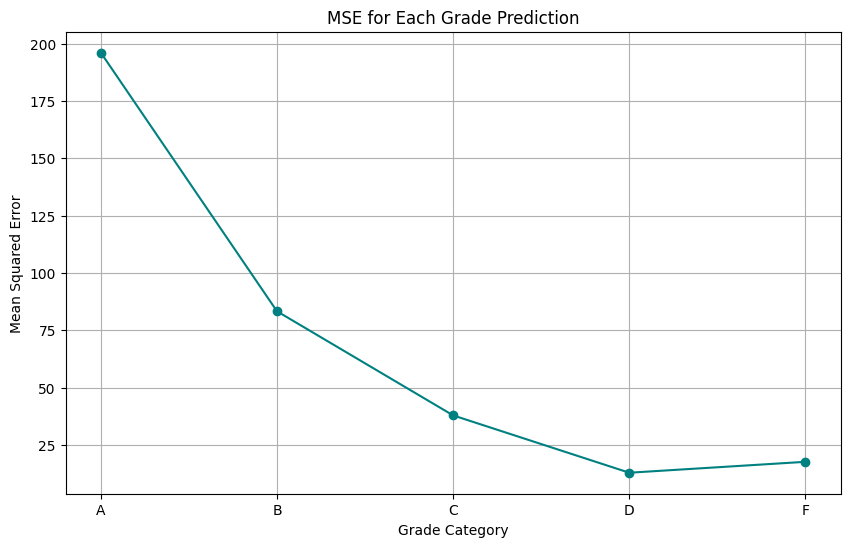

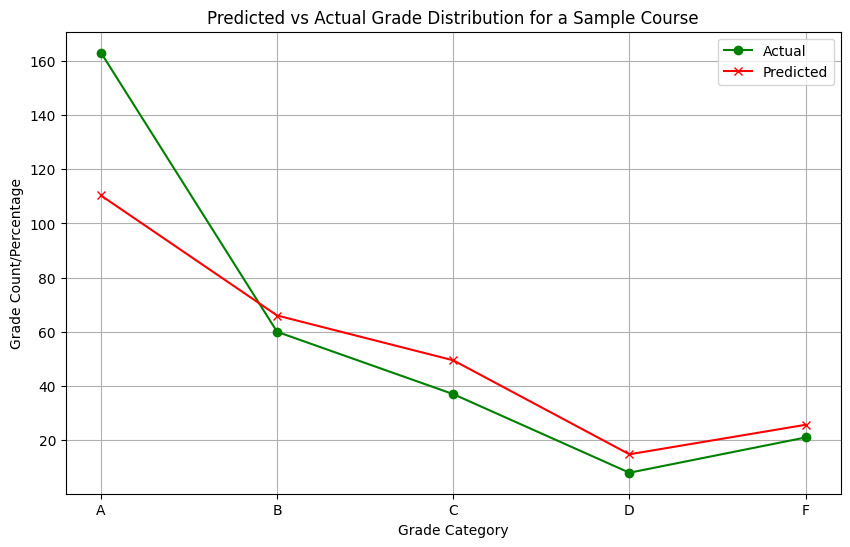


Feature Importances: [0.08159565 0.10785384 0.79478109 0.01576942]


<ipython-input-42-fcb5531a6d58>:146: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=features.columns, y=feature_importances, palette="viridis")


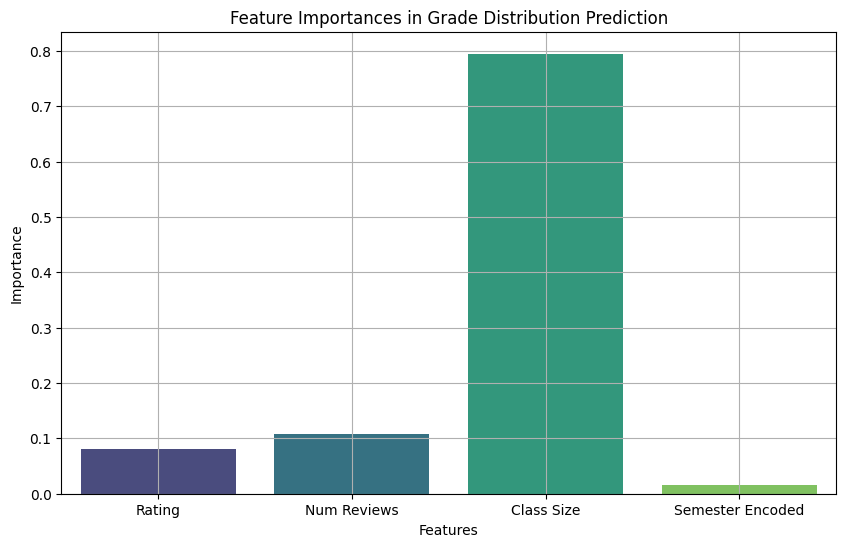

In [42]:
import pandas as pd

# Load the datasets
grade_data = pd.read_excel('CS418_Team5_DataSet.xlsx', sheet_name='GD_CS_14_24')
rmp_data = pd.read_excel('CS418_Team5_DataSet.xlsx', sheet_name='RMP_CS_14_24')
course_desc = pd.read_excel('CS418_Team5_DataSet.xlsx', sheet_name='CS_Descrip')

# Inspect the initial data
print("Grade Data (First 5 Rows):")
print(grade_data.head())

print("\nRMP Data (First 5 Rows):")
print(rmp_data.head())

print("\nCourse Description Data (First 5 Rows):")
print(course_desc.head())

# Check for missing values in 'CRS SUBJ CD' and 'CRS NBR'
print("Grade Data Columns:", grade_data.columns)
print("Missing Values in 'CRS SUBJ CD':", grade_data['CRS SUBJ CD'].isnull().sum())
print("Missing Values in 'CRS NBR':", grade_data['CRS NBR'].isnull().sum())

# Ensure proper formatting of CRS SUBJ CD and CRS NBR to create Course_Code
grade_data['Course_Code'] = grade_data['CRS SUBJ CD'].str.strip() + " " + grade_data['CRS NBR'].astype(str).str.zfill(3).str.strip()

# Inspect the Grade Data to confirm Course_Code creation
print("\nGrade Data with Course_Code (First 5 Rows):")
print(grade_data[['CRS SUBJ CD', 'CRS NBR', 'Course_Code']].head())

# Function to clean and extract first and last names from "Last, First" format
def clean_instructor_name(name):
    parts = name.split(',')
    if len(parts) == 2:
        first_last = parts[1].strip() + ' ' + parts[0].strip()  # "First Last"
        return first_last
    return name.strip()

# Clean up instructor names in both grade data and RMP data
grade_data['Instructor Cleaned'] = grade_data['Primary Instructor'].apply(clean_instructor_name)
rmp_data['Instructor Cleaned'] = rmp_data['Instructor'].apply(clean_instructor_name)

# Merge grade data with RMP data on Cleaned Instructor Name
merged_data = pd.merge(grade_data, rmp_data[['Instructor Cleaned', 'Rating', 'Num Reviews']],
                       left_on='Instructor Cleaned', right_on='Instructor Cleaned', how='left')

# Display the merged data to verify the RMP ratings are added
print("\nMerged Data with RMP (First 5 Rows):")
print(merged_data[['Primary Instructor', 'Instructor Cleaned', 'Rating', 'Num Reviews']].head())

# Check course_desc structure
print("\nCourse Description Columns:", course_desc.columns)
print("Missing Values in 'Course':", course_desc['Course'].isnull().sum())

# Clean up Course column in course_desc to match Course_Code format
course_desc['Course'] = course_desc['Course'].str.strip()

# Merge with course descriptions
merged_data = pd.merge(
    merged_data,
    course_desc[['Course', 'Course Title', 'Description']],  # Use relevant columns from course_desc
    left_on='Course_Code',
    right_on='Course',
    how='left'
)

# Display the merged data to verify Course Title and Description are added
print("\nMerged Data with Course Descriptions (First 5 Rows):")
print(merged_data[['Course_Code', 'Course Title', 'Description', 'Rating', 'Num Reviews']].head())

# Check for missing values
print("\nNumber of missing values in 'Rating':", merged_data['Rating'].isnull().sum())
print("Number of missing values in 'Course Title':", merged_data['Course Title'].isnull().sum())

# Fill missing RMP ratings and reviews with appropriate values
merged_data['Rating'] = merged_data['Rating'].fillna(merged_data['Rating'].mean())
merged_data['Num Reviews'] = merged_data['Num Reviews'].fillna(0)

# Verify filled values
print("\nSample 'Rating' column values after filling:", merged_data['Rating'].head())
print("Sample 'Num Reviews' column values after filling:", merged_data['Num Reviews'].head())

# Feature Engineering
merged_data['Class Size'] = merged_data['Grade Regs']  # Total registered students in the class
merged_data['Semester Encoded'] = pd.Categorical(merged_data['SEMESTER']).codes  # Encode semester as numeric

# Define features and target variables
features = merged_data[['Rating', 'Num Reviews', 'Class Size', 'Semester Encoded']]
target = merged_data[['A', 'B', 'C', 'D', 'F']]

# Check feature ranges for scaling issues
print("\nFeature Statistics:\n", features.describe())

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Verify train-test split sizes
print("\nX_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

# Initialize and train the model
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
model = MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=42))
print("\nTraining model...")
model.fit(X_train, y_train)
print("Training complete.")

# Predict on the test set
from sklearn.metrics import mean_squared_error
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred, multioutput='raw_values')
print("\nMean Squared Error for each grade category:", mse)

# Visualization: MSE for each grade category
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(target.columns, mse, marker='o', color='teal')
plt.title("MSE for Each Grade Prediction")
plt.xlabel("Grade Category")
plt.ylabel("Mean Squared Error")
plt.grid()
plt.show()

# Visualization: Predicted vs. Actual Grades for a sample of the test set
sample_index = 0  # Modify this index to check other test samples
plt.figure(figsize=(10, 6))
plt.plot(target.columns, y_test.iloc[sample_index], label="Actual", marker='o', color='green')
plt.plot(target.columns, y_pred[sample_index], label="Predicted", marker='x', color='red')
plt.title("Predicted vs Actual Grade Distribution for a Sample Course")
plt.xlabel("Grade Category")
plt.ylabel("Grade Count/Percentage")
plt.legend()
plt.grid()
plt.show()

# Feature Importance Visualization
import seaborn as sns
feature_importances = model.estimators_[0].feature_importances_
print("\nFeature Importances:", feature_importances)
plt.figure(figsize=(10, 6))
sns.barplot(x=features.columns, y=feature_importances, palette="viridis")
plt.title("Feature Importances in Grade Distribution Prediction")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.grid()
plt.show()



Feature Statistics:
             Rating  Num Reviews  Class Size  Semester Encoded
count  1247.000000  1247.000000  1247.00000       1247.000000
mean      3.375045    44.377706    74.44988          0.640738
std       0.790862    42.987690    71.72199          0.614858
min       1.000000     0.000000    10.00000          0.000000
25%       2.700000     9.000000    25.00000          0.000000
50%       3.375045    25.000000    49.00000          1.000000
75%       3.900000    82.000000    93.00000          1.000000
max       5.000000   144.000000   440.00000          2.000000

Mean Squared Error for each grade category: [196.01823273  83.28225648  37.89375935  12.90298437  17.65804163]


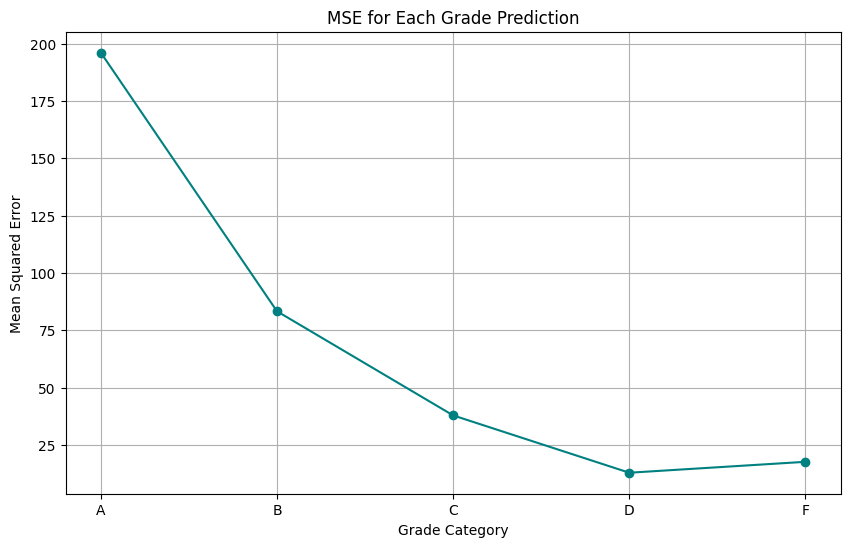

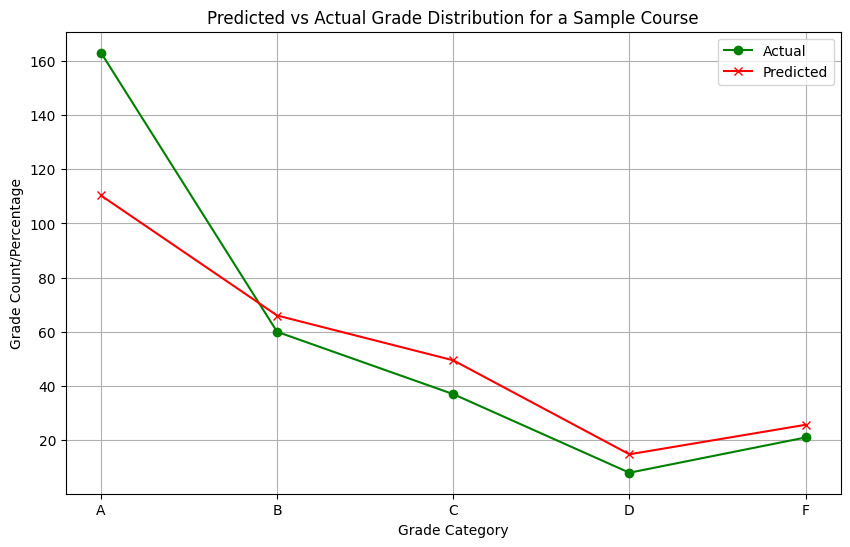

<ipython-input-43-ba41922d47ee>:100: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=features.columns, y=feature_importances, palette="viridis")


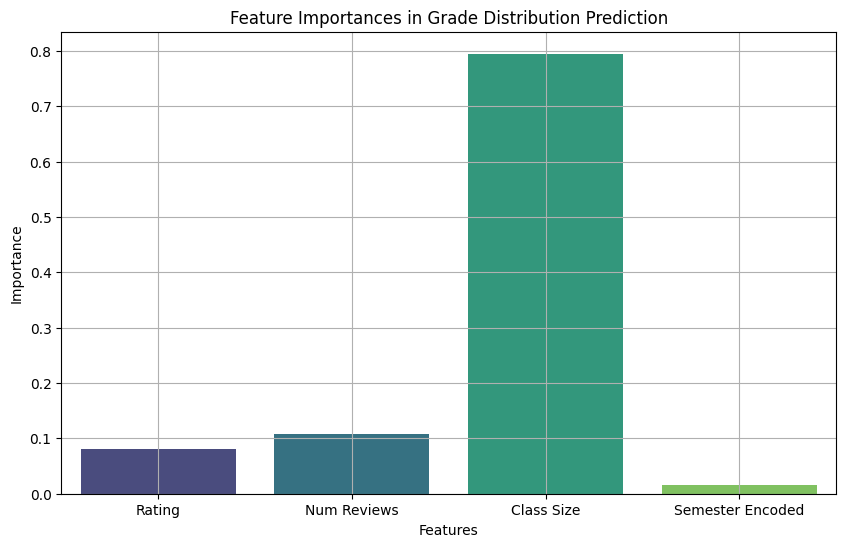

In [43]:
import pandas as pd

# Load the datasets
grade_data = pd.read_excel('CS418_Team5_DataSet.xlsx', sheet_name='GD_CS_14_24')
rmp_data = pd.read_excel('CS418_Team5_DataSet.xlsx', sheet_name='RMP_CS_14_24')
course_desc = pd.read_excel('CS418_Team5_DataSet.xlsx', sheet_name='CS_Descrip')

# Ensure proper formatting of CRS SUBJ CD and CRS NBR to create Course_Code
grade_data['Course_Code'] = grade_data['CRS SUBJ CD'].str.strip() + " " + grade_data['CRS NBR'].astype(str).str.zfill(3).str.strip()

# Function to clean and extract first and last names from "Last, First" format
def clean_instructor_name(name):
    parts = name.split(',')
    if len(parts) == 2:
        first_last = parts[1].strip() + ' ' + parts[0].strip()  # "First Last"
        return first_last
    return name.strip()

# Clean up instructor names in both grade data and RMP data
grade_data['Instructor Cleaned'] = grade_data['Primary Instructor'].apply(clean_instructor_name)
rmp_data['Instructor Cleaned'] = rmp_data['Instructor'].apply(clean_instructor_name)

# Merge grade data with RMP data on Cleaned Instructor Name
merged_data = pd.merge(grade_data, rmp_data[['Instructor Cleaned', 'Rating', 'Num Reviews']],
                       left_on='Instructor Cleaned', right_on='Instructor Cleaned', how='left')

# Clean up Course column in course_desc to match Course_Code format
course_desc['Course'] = course_desc['Course'].str.strip()

# Merge with course descriptions
merged_data = pd.merge(
    merged_data,
    course_desc[['Course', 'Course Title', 'Description']],  # Use relevant columns from course_desc
    left_on='Course_Code',
    right_on='Course',
    how='left'
)

# Fill missing RMP ratings and reviews with appropriate values
merged_data['Rating'] = merged_data['Rating'].fillna(merged_data['Rating'].mean())
merged_data['Num Reviews'] = merged_data['Num Reviews'].fillna(0)

# Feature Engineering
merged_data['Class Size'] = merged_data['Grade Regs']  # Total registered students in the class
merged_data['Semester Encoded'] = pd.Categorical(merged_data['SEMESTER']).codes  # Encode semester as numeric

# Define features and target variables
features = merged_data[['Rating', 'Num Reviews', 'Class Size', 'Semester Encoded']]
target = merged_data[['A', 'B', 'C', 'D', 'F']]

# Feature Statistics (Summary)
print("\nFeature Statistics:\n", features.describe())

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Initialize and train the model
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
model = MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=42))
model.fit(X_train, y_train)

# Predict on the test set
from sklearn.metrics import mean_squared_error
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred, multioutput='raw_values')

# Display the MSE results
print("\nMean Squared Error for each grade category:", mse)

# Visualization: MSE for each grade category
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(target.columns, mse, marker='o', color='teal')
plt.title("MSE for Each Grade Prediction")
plt.xlabel("Grade Category")
plt.ylabel("Mean Squared Error")
plt.grid()
plt.show()

# Visualization: Predicted vs. Actual Grades for a sample of the test set
sample_index = 0  # Modify this index to check other test samples
plt.figure(figsize=(10, 6))
plt.plot(target.columns, y_test.iloc[sample_index], label="Actual", marker='o', color='green')
plt.plot(target.columns, y_pred[sample_index], label="Predicted", marker='x', color='red')
plt.title("Predicted vs Actual Grade Distribution for a Sample Course")
plt.xlabel("Grade Category")
plt.ylabel("Grade Count/Percentage")
plt.legend()
plt.grid()
plt.show()

# Feature Importance Visualization
import seaborn as sns
feature_importances = model.estimators_[0].feature_importances_
plt.figure(figsize=(10, 6))
sns.barplot(x=features.columns, y=feature_importances, palette="viridis")
plt.title("Feature Importances in Grade Distribution Prediction")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.grid()
plt.show()
